<a href="https://colab.research.google.com/github/skrzypczykt/MAchineLearningProjects/blob/main/NeuralNetworksTutorials/MLP_with_ES_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Klasyfikacja binarna za pomocą sieci MLP

In [ ]:
import numpy as np
import math
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import tqdm

#Definicja sieci

####Element wczesnego zatrzymania treningu:

  Trening zatrzymujemy gdy `val_accuracy` nie poprawia się przez `patience` iteracji z rzedu.


####Wariant wstecznej propagacji 
   niestochastyczny
  
####Funkcja aktywacji
  Sigmoida, w każdym memencie możną ją zmienić w pierwszych liniach kodu redefiniując zmienne `sigmoid` oraz 
`sigmoid_derivative` wprowadzając np. skok jednostkowy lub relu.

In [ ]:


beta = 1
sigmoid = lambda _sum: 1/(1 + np.exp(-beta*_sum))
sigmoid_derivative = lambda _sum:  sigmoid(_sum) * (1 - sigmoid(_sum))


class NeuralNetwork:
    def __init__(self, hidden_sizes: List[int], output_size: int, input_size: int) -> None:
        self.sizes = [input_size, *hidden_sizes, output_size]
        self.weights = [[np.random.normal(size=(size_in, size_out)), np.zeros(shape=(1, size_out))] for size_in, size_out in zip(self.sizes[:-1], self.sizes[1:])]  # inicjujemy wagi sieci dla warstw ukrytych
        self.layers = []  #umieszczamy wartosci znajdujace sie w poszczegolnych ukrytych warstwach sieci
        self.activation_function = sigmoid
        self.activation_derivate = sigmoid_derivative

    def predict(self, input_: np.ndarray) -> np.ndarray:
        prediction = input_.copy()
        self.layers = [prediction]
        for weights, biases in self.weights:
            _sum = prediction @ weights + biases
            self.layers.append(_sum)
            prediction = self.activation_function(_sum)
        return prediction

    def fit(self, data: np.ndarray, labels: np.ndarray, iterations: int, alpha: float, validation_data: tuple) -> float:
        errors = []
        val_errors = []
        val_classification_errors = []
        classification_errors = []
        n = data.shape[0]

        best_val_accuracy = 0
        #If we have no improvment for patience epoch then we stop the training.
        patience = 25
        semafor = 0
        for _ in tqdm.tqdm(range(iterations)):

            #Validation step
            y_val_pred = self.predict(validation_data[0])
            val_error = (validation_data[1] - y_val_pred) ** 2
            val_errors.append(np.mean(val_error))

            #Classification Error
            y_val_predicted_classes = np.round(y_val_pred)
            # print(y_prediction_classes)
            val_accuracy = np.mean(y_val_predicted_classes == validation_data[1])
            val_classification_errors.append(1 - val_accuracy)

            #Early stopping module
            
            if semafor == patience:
              return errors, classification_errors, val_errors, val_classification_errors
            else:
              if val_accuracy > best_val_accuracy:
                semafor = 0
                best_val_accuracy = val_accuracy
              else:
                semafor = semafor + 1

            #Forward step
            y_pred = self.predict(data)
            error = (labels - y_pred) ** 2
            errors.append(np.mean(error))

            #Classification Error
            y_prediction_classes = np.round(y_pred)
            # print(y_prediction_classes)
            accuracy = np.mean(y_prediction_classes == labels)
            # print(accuracy)
            ce = 1 - accuracy
            classification_errors.append(ce)

            #Back prop
            gradient = 2 * (y_pred - labels)
            # print("Gradient:" , gradient)

            # print("Layer shapes")
            # [print(layer.shape) for layer in self.layers]
            for indx in range(1, len(self.weights) + 1):
                # print("Layer=", indx)
                indx = -indx
                m = self.weights[indx][0].shape[1]
                k = self.weights[indx][0].shape[0]
                # print("Sumy:", self.activation_derivate(self.layers[indx]))
                # print("GRadient shape przed aktywacja", gradient.shape)
                assert gradient.shape == (n, m)
                # print("Aktywacke", self.layers[-1])
                # print("Akrtywacje obecne shape = ", self.layers[indx].shape)
                gradient = gradient * self.activation_derivate(self.layers[indx])
                assert gradient.shape == (n, m)
                # print("Po fukcji aktywacji", gradient.shape)
                # print("GRadient po przeskalowaniu", gradient)

                #update biases
                self.weights[indx][1] = self.weights[indx][1] - alpha * np.sum(gradient)

                #aktualizacja wag

                gradient_to_be_passed_further = np.array([self.weights[indx][0] * grad for grad in gradient ])


                assert gradient_to_be_passed_further.shape == (n, k, m)
                gradient_to_be_passed_further = gradient_to_be_passed_further.sum(axis = -1)
                assert gradient_to_be_passed_further.shape == (n, k)
                gradient = gradient.reshape(n,1,m)
                # print("gradient before" , gradient.shape)
                # print("actrivation before",  self.activation_function(self.layers[indx - 1]).shape)
                gradient = np.array([a @ g for a, g in zip (self.activation_function(self.layers[indx - 1]).reshape(n,k,1), gradient)]).reshape(n, k, m)
                # print("n,k,m", n,k,m)
                # print("Shahsasdfsape", gradient.shape)
                assert gradient.shape == (n, k, m)
                gradient = np.sum(gradient,axis=-3)
                assert gradient.shape == (k, m)
                self.weights[indx][0] = self.weights[indx][0] - alpha * gradient


                gradient = gradient_to_be_passed_further
              

        # zwracamy wartosc bledu treningu
        return errors, classification_errors, val_errors, val_classification_errors


# Przygotowanie danych

In [ ]:
#iris data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_iris()
columns = data.feature_names

X = data.data
y = data.target

#Wybieramy próbki o etykietach 0 i 2
binary_indices = (y == 0) + (y == 2)
X = X[binary_indices]
y = y[binary_indices]

y[y==2] = 1

#Podział danych na treningowe, walidacyjne i testowe

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Trening

In [ ]:


input_size = X_train.shape[-1]
output_size = 1

max_iterations = 20000
#wspolczynnik uczenia
alpha = 0.1

#tworzymy siec O 2 warstwach ukrytych po 2 neurony w warstwie
network = NeuralNetwork([2,2], output_size, input_size)

# print(network.weights)

#patrzymy jak daje wyniki na podstawie losowych wag - przed treningiwem
y_pred = network.predict(X_train)
print('Predictions before training:' ,y_pred)

#uruchamiamy trening
training_history = network.fit(X_train, y_train.reshape(-1,1), iterations=max_iterations, alpha=alpha, validation_data = (X_val, y_val.reshape(-1,1)))
# print("Blad na danych treningowych: \n", "\tBłąd bezwzględny:", absolute_error, "\tBłąd średniokwadratowy:",error )

print(network.weights)
# patrzymy jak daje wyniki na podstawie nauczonych wag - po treningu
y_pred = network.predict(X_train)
print('Predictions:' ,y_pred)

  0%|          | 0/20000 [00:00<?, ?it/s]

Predictions before training: [[0.65007233]
 [0.66326985]
 [0.6422219 ]
 [0.63236992]
 [0.62279209]
 [0.61831834]
 [0.62083983]
 [0.66180079]
 [0.61753991]
 [0.64180768]
 [0.65136375]
 [0.66323759]
 [0.61643668]
 [0.61436559]
 [0.62509181]
 [0.63422855]
 [0.61641137]
 [0.62150721]
 [0.64425954]
 [0.62048036]
 [0.63120534]
 [0.64193611]
 [0.65934346]
 [0.65466609]
 [0.61589218]
 [0.61493226]
 [0.62146476]
 [0.61592983]
 [0.63072317]
 [0.66248342]
 [0.66076942]
 [0.65842274]
 [0.66389733]
 [0.63411347]
 [0.66575168]
 [0.62443483]
 [0.63848795]
 [0.66116776]
 [0.62624502]
 [0.66622434]
 [0.64131163]
 [0.65951762]
 [0.62257211]
 [0.6161081 ]
 [0.61722641]
 [0.61836174]
 [0.66098563]
 [0.64020908]
 [0.64640295]
 [0.66155517]
 [0.63422855]
 [0.64461504]
 [0.62344588]
 [0.66127998]
 [0.61879399]
 [0.66039601]
 [0.63006285]
 [0.61584018]
 [0.61557829]
 [0.61957617]
 [0.66399443]
 [0.66234351]
 [0.65994404]
 [0.65549336]
 [0.62068909]
 [0.6267647 ]
 [0.64519688]
 [0.64002513]
 [0.61621258]
 [0.6

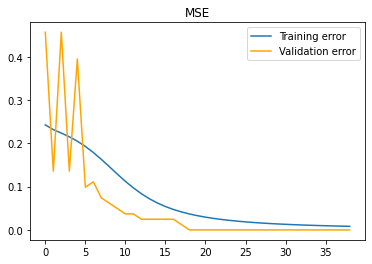

In [ ]:
plt.plot(range(len(training_history[0])), training_history[0], label="Training error")
plt.plot(range(len(training_history[1])), training_history[1], color='orange', label="Validation error")
plt.title("MSE")
plt.legend()

Text(0.5, 1.0, 'Classification error')

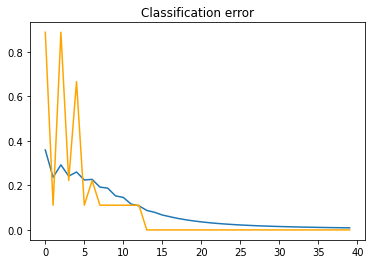

In [ ]:
#Wykres validation accuracy
plt.plot(range(len(training_history[2])), training_history[2], label="Training classification error")
plt.plot(range(len(training_history[3])), training_history[3], color='orange',  label="Validation classification error")
plt.title("Classification error")

Ostatecznie dla danych testowych:

In [ ]:
#Test accuracy
y_pred = network.predict(X_test)

y_val_predicted_classes = np.round(y_pred)
# print(y_prediction_classes)
test_accuracy = np.mean(y_val_predicted_classes == y_test.reshape(-1,1))
print("Test accuracy:", test_accuracy)

Test accuracy: 1.0
